#### **This notebook contains the functions used to clean the spectra.**

Import Libraries

In [41]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns
from Spectra_Preparation_Functions import *

Read the spectral data

In [42]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")

In [43]:
df = df[(df['WaveNumber'] >= 400) & (df['WaveNumber'] <= 1800)]

In [44]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


#### **Select the chosen cleaning parameters then run the functions**

Choose the Parameters

In [45]:
# # Best Full Spectrum Parameters

# lam = 10 ** 7
# p = 0.05
# window_size = 51
# poly_order = 2

# Best 400-1800 Parameters

# lam = 10 ** 8
# p = 0.01
# window_size = 51
# poly_order = 3

# Standard Parameters
# despike_ma = 25
# despike_threshold = 3.75
# lam = 10 ** 7
# p = 0.001
# window_size = 21
# poly_order = 2

# More parameters from optuna
# despike_ma = 19
# despike_threshold = 5.75
# lam = 10**10
# p = 0.049

# Clean Params for Pagerank weights
# despike_ma = 19
# despike_threshold = 5.75
# lam = 10**8
# p = 0.049
# window_size = 11
# poly_order = 2

# pagerank_cutoff = 0.902461
# despike_ma = 57
# despike_threshold = 3.75
# lam = 10 ** 11
# p = 0.074
# window_size = 51
# poly_order = 3

# Best groupkfold cleaning param(no pagerank)
p = 0.031
despike_ma = 26
despike_threshold = 5
poly_order = 3
window_size = 26
lam = 10 ** 9

#### **Here is an example on 1 spectrum**

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

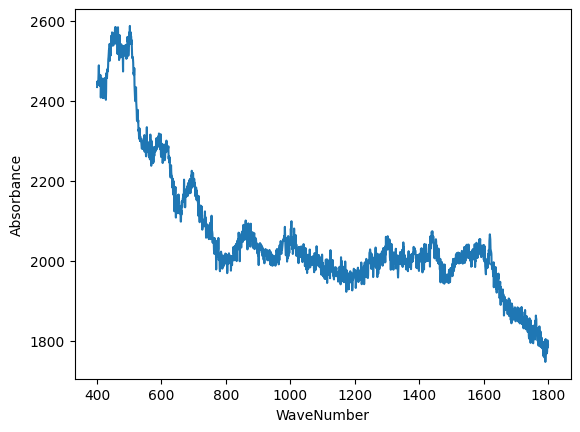

In [46]:
sample = df[df['SpecID'] == "201210-1-07"]
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

/tmp/ipykernel_112902/2465510453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Despiked_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

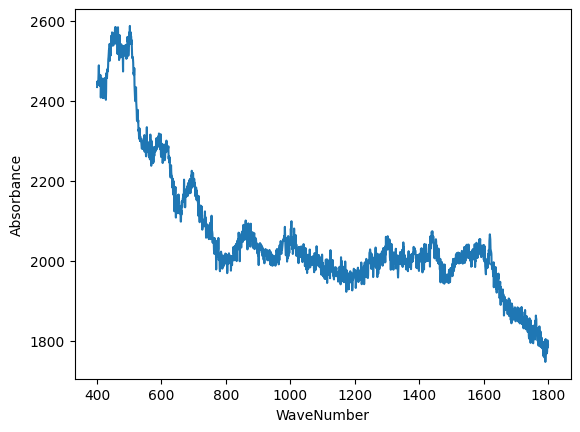

In [47]:
sample['Despiked_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

/tmp/ipykernel_112902/3348993900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Despiked_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

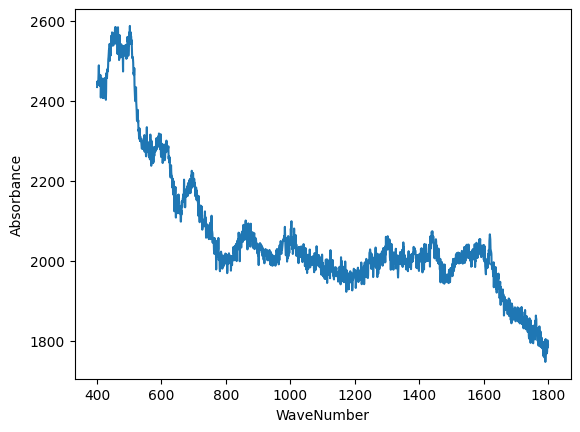

In [48]:
sample['Despiked_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

/tmp/ipykernel_112902/742450235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))


<Axes: xlabel='WaveNumber', ylabel='Despiked_Absorbance'>

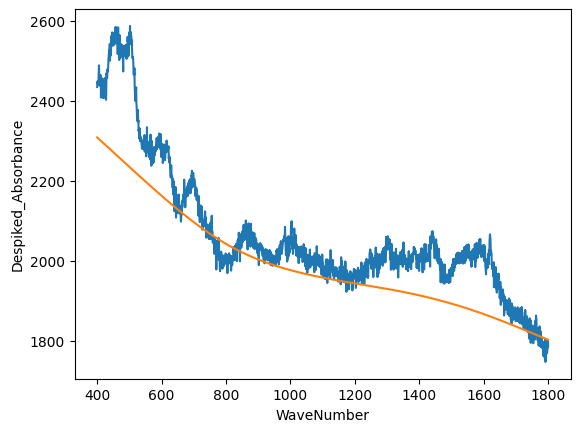

In [49]:
sample['Baseline'] = sample.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
sns.lineplot(x="WaveNumber", y="Despiked_Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)

Subtract the baseline.

/tmp/ipykernel_112902/1303904700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

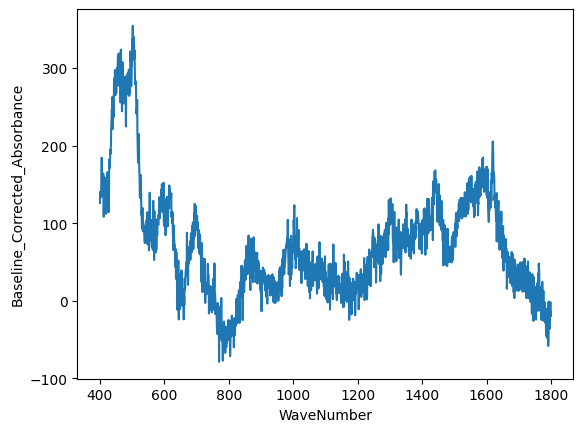

In [50]:
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Smooth the Baseline_Corrected_Spectrum

/tmp/ipykernel_112902/1425479424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

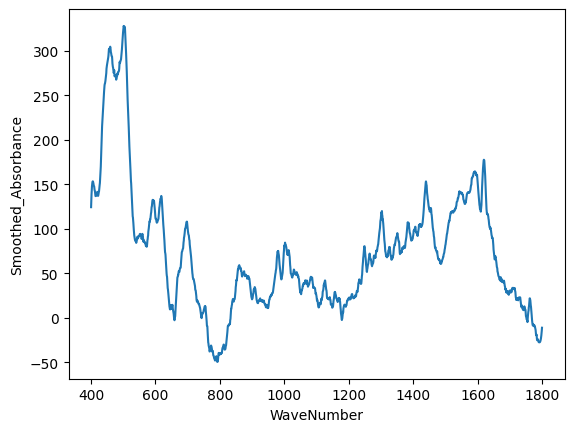

In [51]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

In [52]:
# # Despike

df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))

In [53]:
df['Baseline'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))

In [54]:
df['Baseline_Corrected_Absorbance'] = df['Absorbance'] - df['Baseline']

In [55]:
df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [56]:
# Optional Scaling
# df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Smooth_Baseline_Corrected'].transform(lambda x: normalise(x))
# df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Smooth_Baseline_Corrected'].transform(lambda x: vector_normalise(x))
# df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Smooth_Baseline_Corrected'].transform(lambda x: svn_normalise(x))

In [57]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Baseline,Baseline_Corrected_Absorbance,Smooth_Baseline_Corrected
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,1729.979778,35.683022,40.703772
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,1729.824757,44.956143,37.426108
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,1729.669737,39.360463,34.867161
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,1729.514717,26.907283,32.960484
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,1729.359696,29.509304,31.639630
...,...,...,...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,1646.444840,-29.052240,-14.516414
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,1645.658439,-12.567339,-14.950487
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,1644.872038,-11.564438,-15.799709
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,1644.085636,-2.219136,-17.110115


In [58]:
df = df.drop(columns=['Absorbance', 'Baseline', 'Baseline_Corrected_Absorbance'])
df = df.rename(columns={'Smooth_Baseline_Corrected':'Absorbance'})

In [59]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
293,201210-1-00,293,400.22778,201210-1,Normal,40.703772
294,201210-1-00,294,400.91116,201210-1,Normal,37.426108
295,201210-1-00,295,401.59454,201210-1,Normal,34.867161
296,201210-1-00,296,402.27789,201210-1,Normal,32.960484
297,201210-1-00,297,402.96127,201210-1,Normal,31.639630
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-14.516414
8023278,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-14.950487
8023279,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-15.799709
8023280,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-17.110115


In [60]:
#df.to_csv("../../data/standard_cleaning.csv", index=False)
df.to_csv("../../data/current_clean_spectrum.csv", index=False)
# df.to_csv("../../data/400-1800_spike_removed.csv", index=False)